# TPC-H Multi-Tenant in PostgreSQL with PVC

In [1]:
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import seaborn as sns
import re

from bexhoma import collectors

%matplotlib inline

In [2]:
#path = r"C:\data\benchmarks"
path = r"/home/perdelt/benchmarks"
filename_prefix = ''

In [3]:
def sanitize_filename(title, max_length=100):
    # Replace non-alphanumeric characters with underscores
    safe = re.sub(r'[^a-zA-Z0-9-_]+', '_', title.strip())
    # Truncate to a safe length
    return safe[:max_length].rstrip('_')
    
def plot_bars(df, y, title, estimator):
    df_plot = df.copy()
    #df_plot = df_plot[df_plot['client']=='1']
    df_plot = df_plot.sort_values(['num_tenants','type'])
    # Hatch styles for each type
    hatch_map = {
        'container': '/',
        'database': '\\',
        'schema': 'x'
    }
    hue_order = ['container', 'database', 'schema']
    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df_plot,
        x='num_tenants',
        y=y,
        hue='type',
        estimator=estimator,
        palette='Set2',
        hue_order=hue_order
    )
    """
    for bar in ax.patches:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X: center of bar
                height,                             # Y: top of bar
                f'{height:.1f}',                    # Text (1 decimal place)
                ha='center', va='bottom', fontsize=8
            )
    """
    # Get tick positions (i.e., the x-axis categories)
    xticks = ax.get_xticks()
    bar_width = ax.patches[0].get_width()
    # Create a mapping from (num_tenants, type) to hatch
    grouped = df_plot.groupby(['num_tenants', 'type']).agg({y: estimator}).reset_index()
    #print(grouped)
    grouped_dict = {(row['num_tenants'], row['type']): hatch_map[row['type']] for _, row in grouped.iterrows()}
    bars = sorted(ax.patches, key=lambda bar: bar.get_x() if bar.get_height() > 0 else 10000)
    for bar, (_, row) in zip(bars, grouped.iterrows()):
        bar.my_id = (row['num_tenants'], row['type'])  # or anything else like an index or uuid
        bar.set_hatch(hatch_map[row['type']]) #grouped_dict[(bar.my_id)])
        bar.set_edgecolor('black')
        bar.set_linewidth(1)
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        hatch = hatch_map.get(label, '')
        handle.set_hatch(hatch)
    # Final touches
    plt.legend(title='Type')
    ax.legend(fontsize=18)
    #ax.legend(fontsize=18, loc='upper left', bbox_to_anchor=(1, 1))  # move outside
    plt.title(f"{title}", fontsize=24)
    #plt.title(f"{title} by Number of Tenants and Type", fontsize=24)
    plt.xlabel("Number of Tenants", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    # Remove y-axis label
    ax.set_ylabel('')  # or ax.set(ylabel='')
    plt.tight_layout()
    filename = "tpch_" + sanitize_filename(title) + ".png"    
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()



In [4]:
def plot_boxplots(df, y, title):
    plt.figure(figsize=(10, 6))
    # Hatch styles for each type
    hatch_map = {
        'container': '/',
        'database': '\\',
        'schema': 'x'
    }
    hue_order = ['container', 'database', 'schema']
    
    # Plot boxplots grouped by num_tenants and colored by type
    ax = sns.boxplot(
        data=df,
        x='num_tenants',
        y=y,#'Goodput (requests/second)',
        hue='type',
        palette='Set2'  # consistent colors per type
    )
    # Add vertical separator lines between groups
    # Get the number of unique num_tenants and type
    num_groups = df['num_tenants'].nunique()
    num_types = df['type'].nunique()
    
    # Extract hue order
    hue_order = ax.get_legend_handles_labels()[1]
    num_hue = len(hue_order)
    
    # Get hue order from seaborn (types)
    _, type_order = ax.get_legend_handles_labels()
    num_types = len(type_order)
    
    #print(len(ax.patches))
    # Set hatches correctly: patches are grouped by x then by hue
    for i, patch in enumerate(ax.patches):
        #print(i)
        type_index = i // (num_groups)
        if type_index >= num_types:
            break
        type_name = type_order[type_index]
        patch.set_hatch(hatch_map.get(type_name, ''))
        #print(hatch_map.get(type_name, ''))
        patch.set_edgecolor('black')
        patch.set_linewidth(1)
    
    # Each num_tenants group has num_types boxes
    for i in range(1, num_groups):
        xpos = i - 0.5 #0.5
        ax.axvline(x=xpos, color='gray', linestyle='--', alpha=0.5)
    
    
    # Update legend with matching hatches
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        hatch = hatch_map.get(label, '')
        handle.set_hatch(hatch)
        handle.set_edgecolor('black')
        handle.set_linewidth(1)
    
    #title = "Goodput [req/s] Distribution per Tenant"
    plt.title(title, fontsize=24)
    plt.xlabel("Number of Tenants")
    plt.ylabel("")#"Goodput (requests/second)")
    plt.xlabel("Number of Tenants", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    plt.legend(title="Type")
    ax.legend(fontsize=18)
    plt.tight_layout()
    filename = "tpch_" + filename_prefix + sanitize_filename(title) + ".png"    
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

# Container

In [5]:
codes = ['1751049830', '1751042932', '1751036351', '1751030495', '1751024409', '1751018248', '1751119375', '1751111813', '1751104451', '1751126280', '1751134502', '1751142830',
         '1751150564', '1751178052', '1751186509',
         '1751194758', # schema 6
         '1751204267', # db 6
         '1751223797', # container 6
         '1751270408',
         '1751281756',
         #'1751270408', # schema 7
         #'1751281756', # db 7
         #'1751294606', # container 7
         '1751303210', # schema 8
         '1751315193', # db 8
         #'1751327437', # container 8
         '1751337551', # schema 9
         #'1751351420', # db 9 OOM
         '1751437705', # db 9
         '1751359843', # schema 10
         '1751468423', # db 10
        ]

codes

['1751049830',
 '1751042932',
 '1751036351',
 '1751030495',
 '1751024409',
 '1751018248',
 '1751119375',
 '1751111813',
 '1751104451',
 '1751126280',
 '1751134502',
 '1751142830',
 '1751150564',
 '1751178052',
 '1751186509',
 '1751194758',
 '1751204267',
 '1751223797',
 '1751270408',
 '1751281756',
 '1751303210',
 '1751315193',
 '1751337551',
 '1751437705',
 '1751359843',
 '1751468423']

## Per Tenant

In [6]:
collect = collectors.default(path, codes)
#df_performance = get_performance_all_single(codes)
#df_performance
df_performance = collect.get_performance_all_single()
df_performance

,total_timer_execution,Power@Size [~Q/h],Geo Times [s],SF,experiment_run,client,time [s],count,num_of_queries,Throughput@Size,type,num_tenants
DBMS,,,,,,,,,,,,
PostgreSQL-BHT-1-0-1-1,5.581958,6449.350079,5.581958,10.0,1,1,1931,1,22,410.15,container,2
PostgreSQL-BHT-1-1-1-1,5.725308,6287.871693,5.725308,10.0,1,1,1961,1,22,403.88,container,2
PostgreSQL-BHT-1-0-2-1,5.600174,6428.371549,5.600174,10.0,1,2,1928,1,22,410.79,container,2
PostgreSQL-BHT-1-1-2-1,5.662387,6357.742695,5.662387,10.0,1,2,1935,1,22,409.30,container,2
PostgreSQL-BHT-2-1-1,5.805220,6201.315561,5.805220,10.0,1,1,1980,1,22,400.00,database,2
PostgreSQL-BHT-2-1-2,5.859996,6143.349100,5.859996,10.0,1,1,1995,1,22,396.99,database,2
PostgreSQL-BHT-2-2-1,5.786509,6221.367407,5.786509,10.0,1,2,1967,1,22,402.64,database,2
PostgreSQL-BHT-2-2-2,5.816515,6189.273202,5.816515,10.0,1,2,1983,1,22,399.39,database,2
PostgreSQL-BHT-2-1-1,5.804136,6202.473081,5.804136,10.0,1,1,1999,1,22,396.20,schema,2


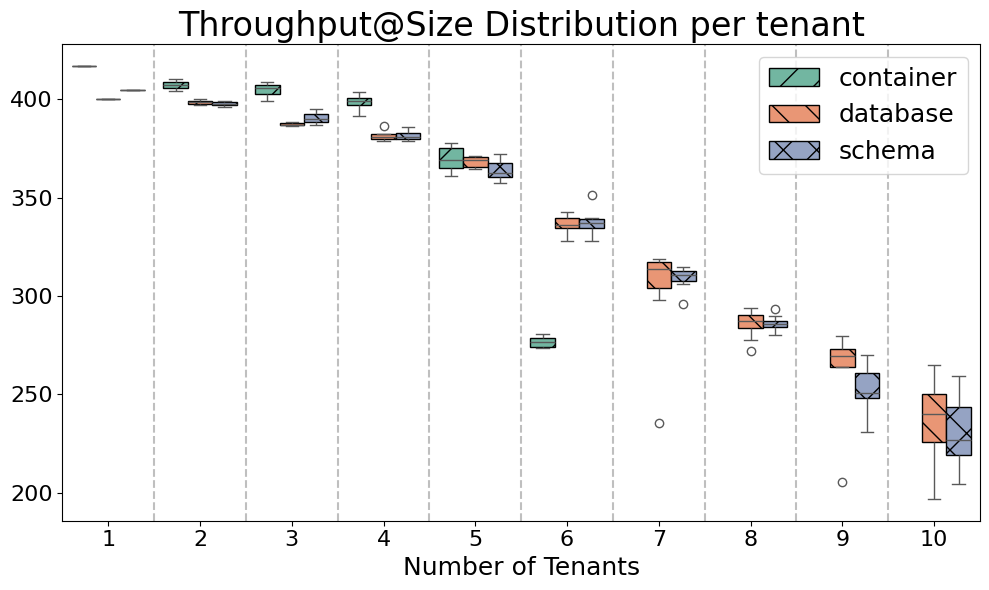

In [7]:
df = df_performance[df_performance['client']==1]
#df = df_performance.copy()
plot_boxplots(df, y='Throughput@Size', title='Throughput@Size Distribution per tenant')

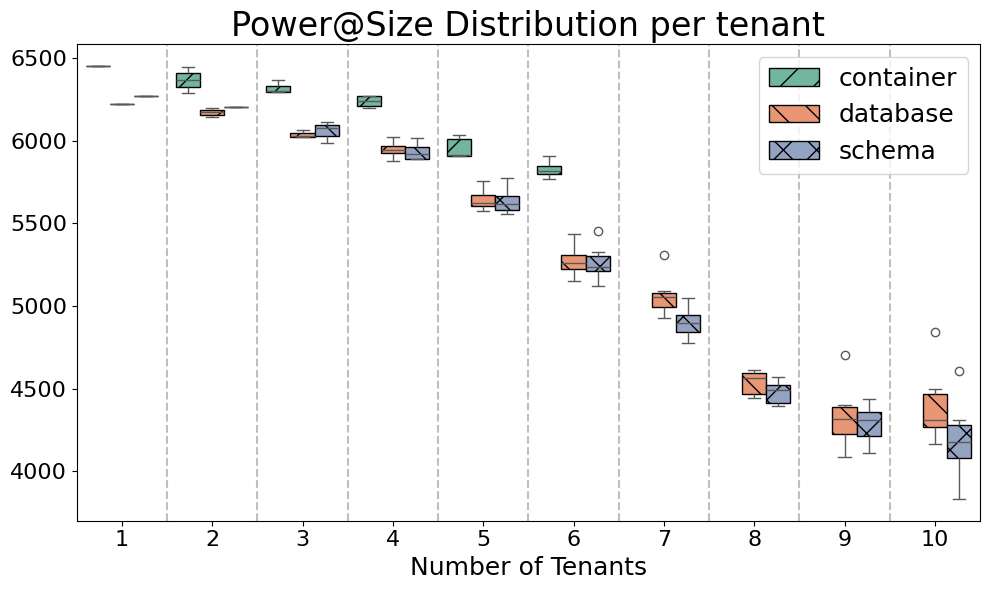

In [8]:
df = df_performance[df_performance['client']==1]
#df = df_performance.copy()
plot_boxplots(df, y='Power@Size [~Q/h]', title='Power@Size Distribution per tenant')

## Per Total

In [9]:
df_performance = collect.get_performance_all()
df_performance

,client,Throughput@Size,time [s],num_of_queries,SF,count,Power@Size [~Q/h],type,num_tenants
0,1,807.75,1961,22,10.0,2,6368.099072,container,2
1,2,818.60,1935,22,10.0,2,6392.959585,container,2
0,1,793.98,1995,22,10.0,2,6172.264282,database,2
1,2,798.79,1983,22,10.0,2,6205.299555,database,2
0,1,792.40,1999,22,10.0,2,6204.870707,schema,2
1,2,793.19,1997,22,10.0,2,6193.703735,schema,2
0,1,416.84,1900,22,10.0,1,6453.282885,container,1
1,2,412.29,1921,22,10.0,1,6399.072262,container,1
0,1,400.00,1980,22,10.0,1,6226.076538,database,1
1,2,402.64,1967,22,10.0,1,6270.759668,database,1


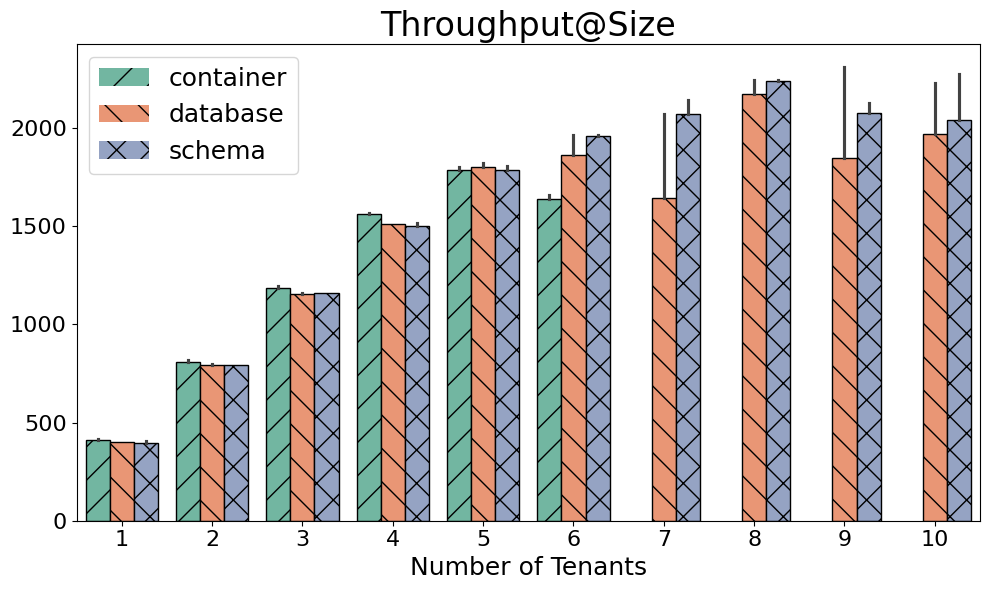

In [10]:
plot_bars(df_performance, y='Throughput@Size', title='Throughput@Size', estimator='min')

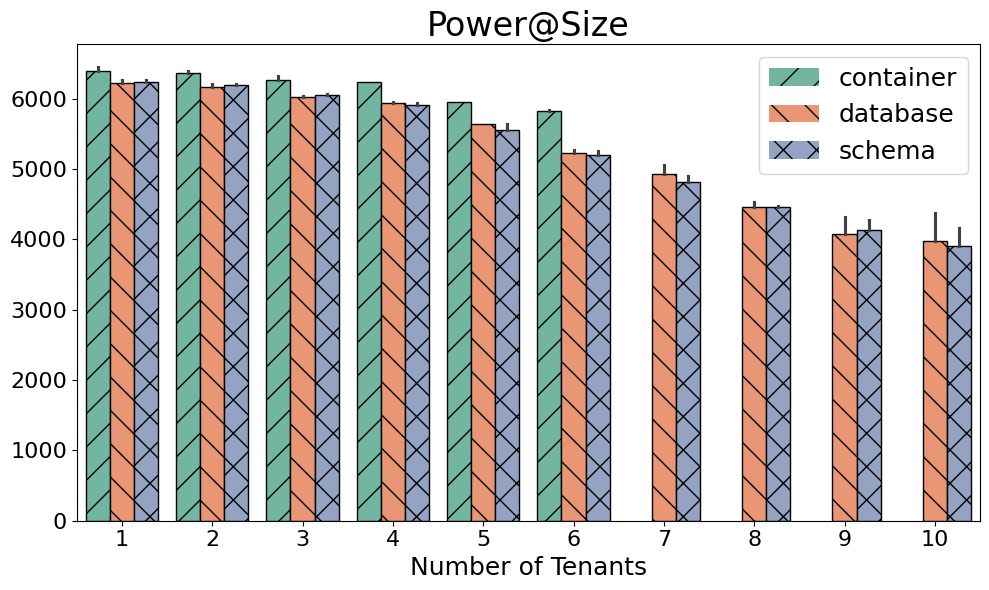

In [11]:
plot_bars(df_performance, y='Power@Size [~Q/h]', title='Power@Size', estimator='min')

In [12]:
df_performance = collect.get_loading_time_max_all()
df_performance

,time_load,time_ingest,time_check,terminals,pods,tenant,client,datadisk,type,num_tenants
PostgreSQL-BHT-1-0-1-1,2436.0,875.0,1558.0,0,1,0,1,27211,container,2
PostgreSQL-BHT-1-0-2-1,2436.0,875.0,1558.0,0,1,0,2,27211,container,2
PostgreSQL-BHT-1-1-1-1,2419.0,871.0,1544.0,0,1,1,1,27211,container,2
PostgreSQL-BHT-1-1-2-1,2419.0,871.0,1544.0,0,1,1,2,27211,container,2
PostgreSQL-BHT-2-1-1,3616.0,1206.0,2172.0,0,2,,1,54413,database,2
PostgreSQL-BHT-2-1-2,3616.0,1206.0,2172.0,0,2,,1,54413,database,2
PostgreSQL-BHT-2-2-1,3616.0,1206.0,2172.0,0,2,,2,54413,database,2
PostgreSQL-BHT-2-2-2,3616.0,1206.0,2172.0,0,2,,2,54413,database,2
PostgreSQL-BHT-2-1-1,3103.0,1194.0,1905.0,0,2,,1,54383,schema,2
PostgreSQL-BHT-2-1-2,3103.0,1194.0,1905.0,0,2,,1,54383,schema,2


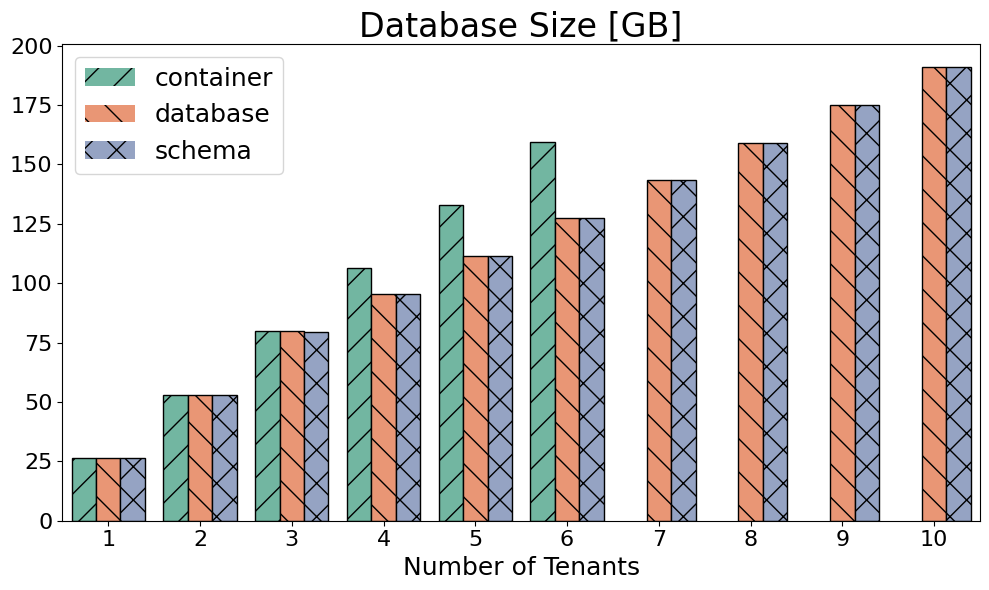

In [13]:
df_performance_first = df_performance[df_performance['client'] == '1']
# Divide datadisk by the count of rows with the same type and num_tenants
df = df_performance_first.copy()
# Create a mask for rows where type is not "container"
mask = df['type'] != 'container'

# Only apply the group count to the relevant rows
group_counts = df[mask].groupby(['type', 'num_tenants'])['datadisk'].transform('count')

# Initialize the column with NaN (or 0, if preferred)
df['datadisk_normalized'] = df['datadisk'] / 1024

# Apply the normalized value only where the mask is True
df.loc[mask, 'datadisk_normalized'] = df.loc[mask, 'datadisk'] / group_counts / 1024

plot_bars(df, y='datadisk_normalized', title='Database Size [GB]', estimator='sum')

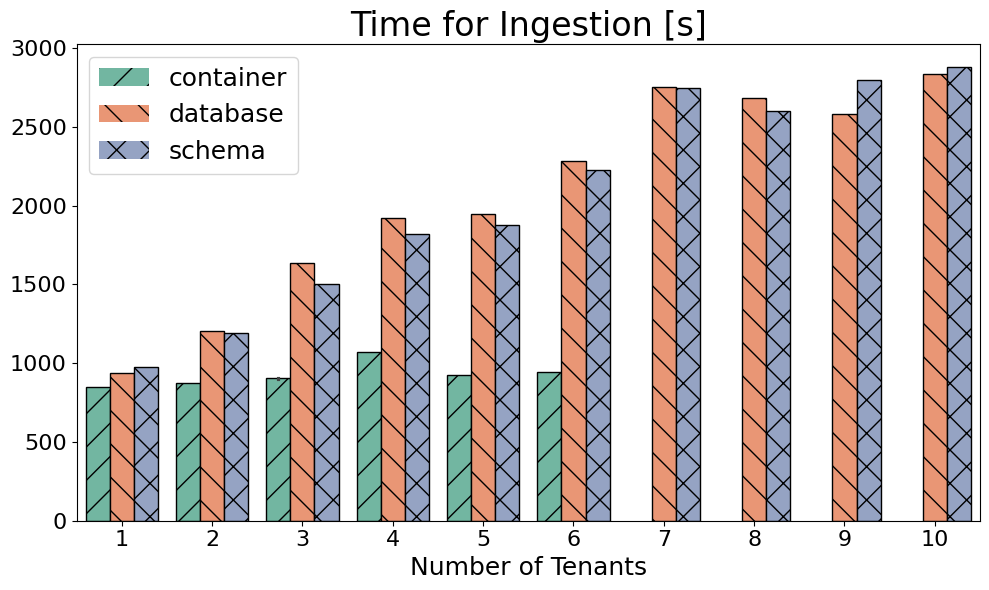

In [14]:
plot_bars(df_performance, y='time_ingest', title='Time for Ingestion [s]', estimator='max')

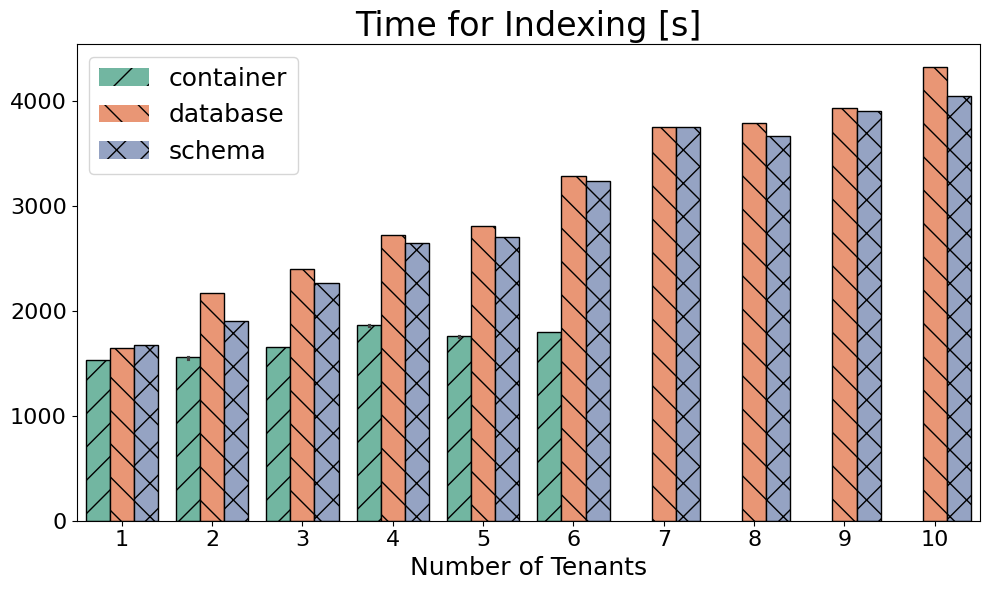

In [15]:
plot_bars(df_performance, y='time_check', title='Time for Indexing [s]', estimator='max')

## Hardware Benchmarking

In [16]:
df_performance = collect.get_monitoring_all(type="stream")
df_performance = df_performance[df_performance['client'] == '1']
df_performance = df_performance.sort_values(['num_tenants', 'type'])
df_performance

,client,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,CPU Throttled,Locks,Access Exclusive,Access Share,Exclusive,...,Heap Reads,Heap Hits,Sync Time,Write Time,Number Autoanalyze,Number Autovacuum,Cache Hit Ratio [%],Variance of Core Util [%],type,num_tenants
0,1,10249.41,57.44,73.35,7.95,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,container,1
0,1,10597.67,57.45,73.36,7.98,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,database,1
0,1,10827.06,57.44,73.35,7.98,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,schema,1
0,1,21122.16,102.01,133.83,15.92,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,container,2
0,1,21627.18,73.43,104.86,14.84,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,database,2
0,1,21782.59,58.97,90.77,14.08,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,schema,2
0,1,32000.65,164.70,208.89,23.93,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,container,3
0,1,33336.32,127.23,174.93,21.61,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,database,3
0,1,33096.24,85.15,131.77,20.91,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,schema,3
0,1,43177.98,229.76,286.85,31.30,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,container,4


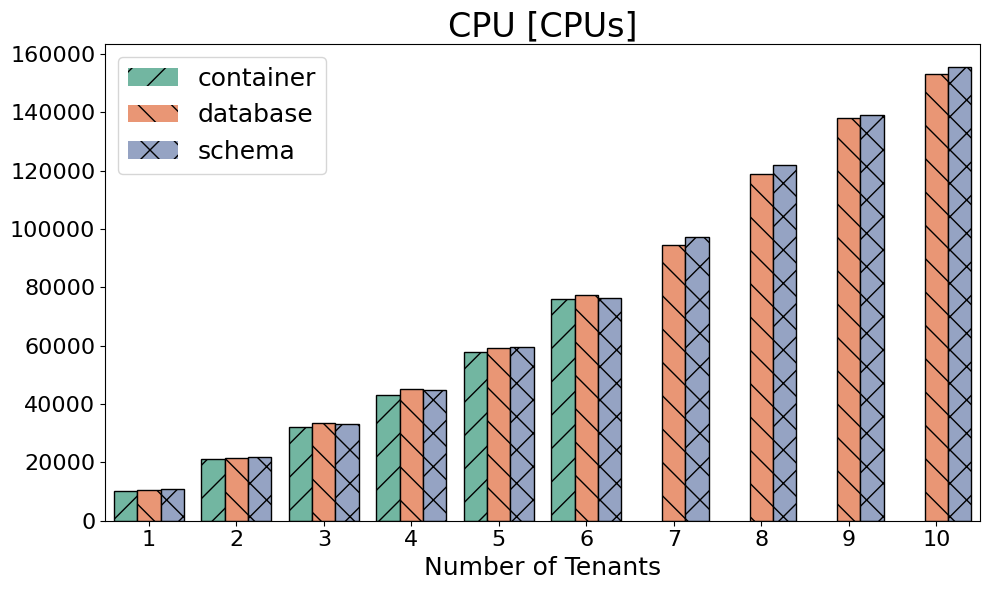

In [17]:
plot_bars(df_performance, y='CPU [CPUs]', title='CPU [CPUs]', estimator='max')

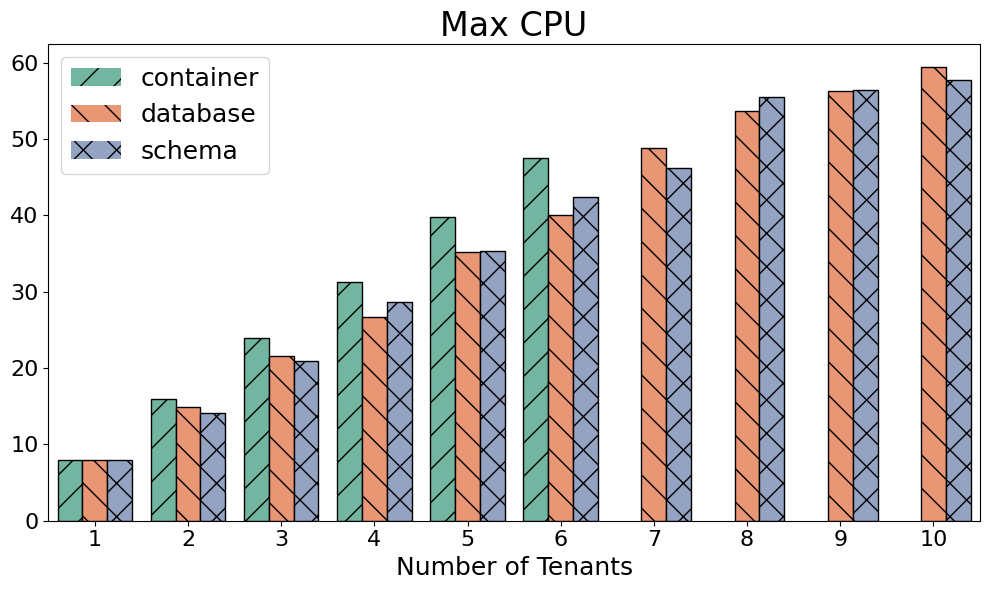

In [18]:
plot_bars(df_performance, y='Max CPU', title='Max CPU', estimator='sum')

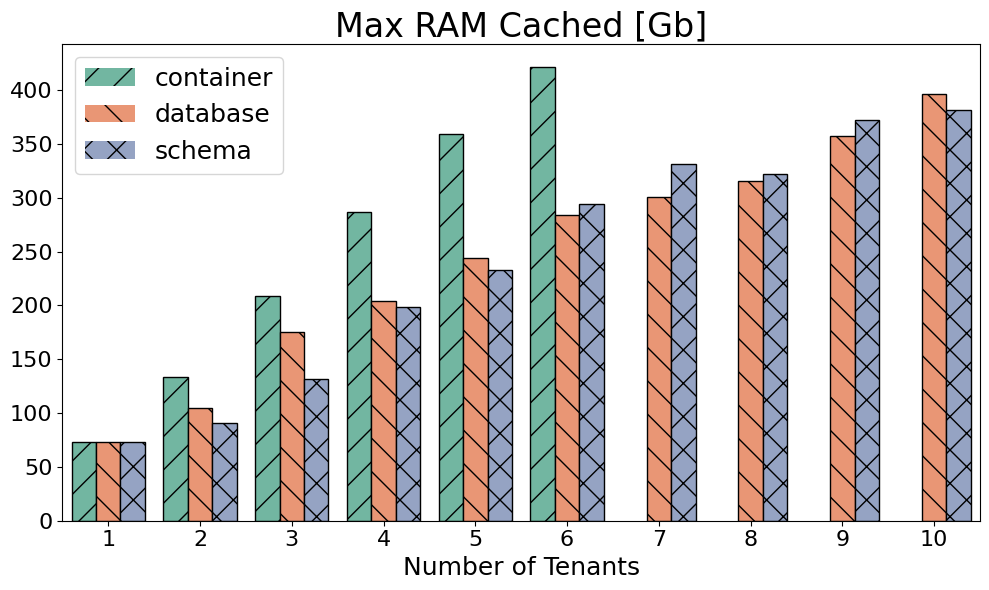

In [19]:
plot_bars(df_performance, y='Max RAM Cached [Gb]', title='Max RAM Cached [Gb]', estimator='sum')

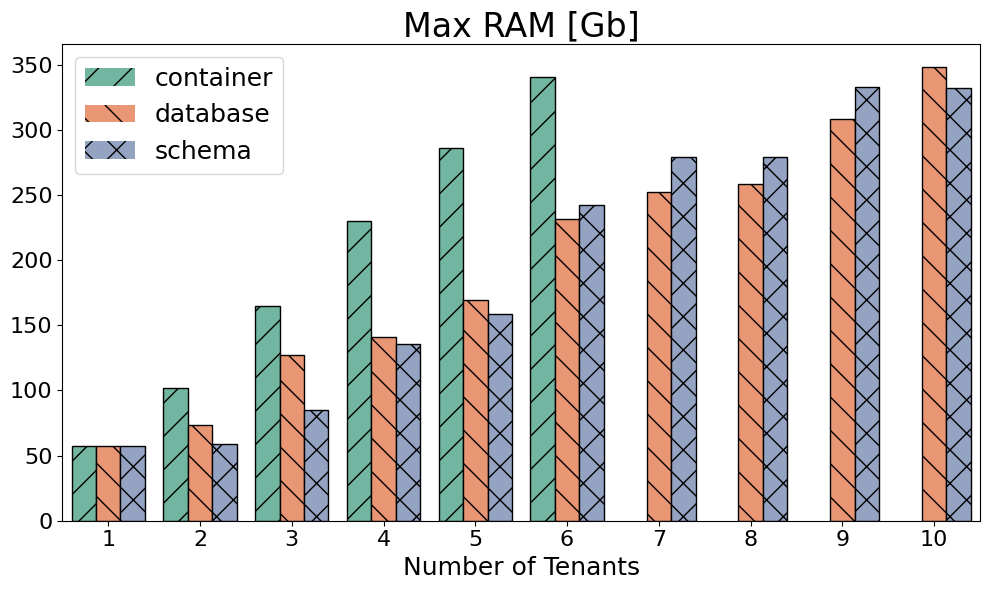

In [20]:
plot_bars(df_performance, y='Max RAM [Gb]', title='Max RAM [Gb]', estimator='sum')

## Hardware Loading

In [21]:
df_performance = collect.get_monitoring_all(type="loading")
df_performance = df_performance[df_performance['client'] == '1']
df_performance = df_performance.sort_values(['num_tenants', 'type'])
df_performance

,client,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,CPU Throttled,Locks,Access Exclusive,Access Share,Exclusive,...,Heap Reads,Heap Hits,Sync Time,Write Time,Number Autoanalyze,Number Autovacuum,Cache Hit Ratio [%],Variance of Core Util [%],type,num_tenants
0,1,1348.45,16.15,31.88,2.73,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,container,1
0,1,1364.01,16.37,31.62,3.88,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,database,1
0,1,1343.99,17.09,31.88,2.41,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,schema,1
0,1,2639.58,33.41,63.53,5.20,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,container,2
0,1,2769.23,29.35,62.46,5.46,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,database,2
0,1,2776.29,30.39,60.20,2.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,schema,2
0,1,4188.86,49.97,94.75,11.95,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,container,3
0,1,4253.43,44.49,90.73,3.51,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,database,3
0,1,4281.17,42.53,90.13,7.66,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,schema,3
0,1,5468.21,64.13,126.60,11.94,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,container,4


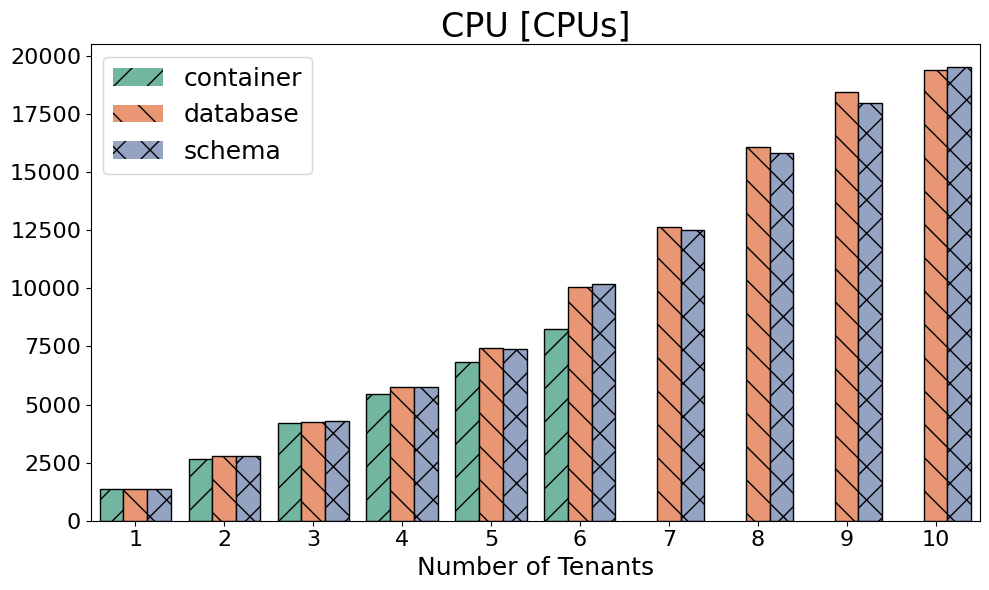

In [22]:
plot_bars(df_performance, y='CPU [CPUs]', title='CPU [CPUs]', estimator='max')

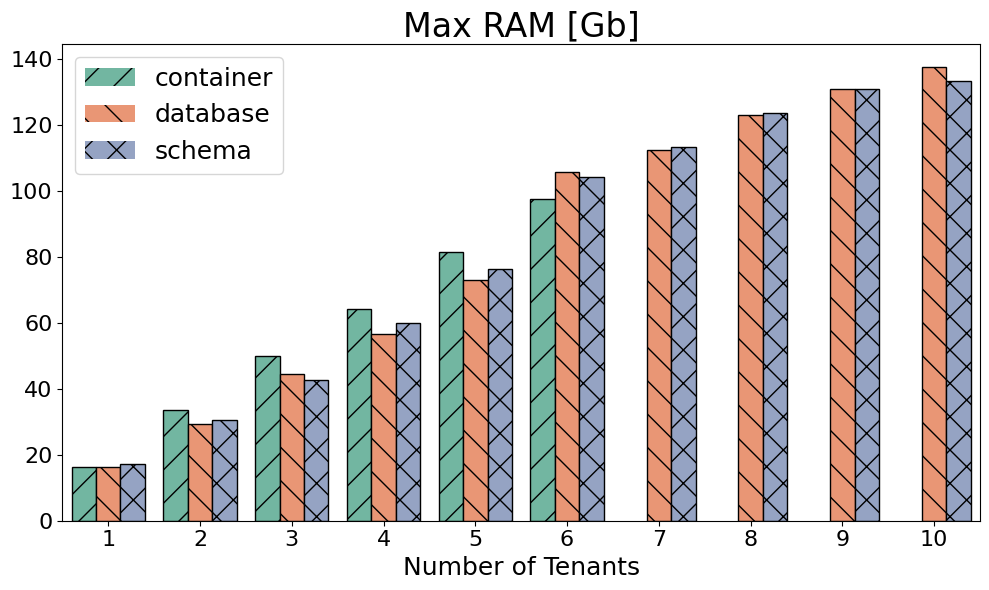

In [23]:
plot_bars(df_performance, y='Max RAM [Gb]', title='Max RAM [Gb]', estimator='sum')

# Efficiency

In [24]:
client = 1

df_performance_monitoring = collect.get_monitoring_all(type="stream")
df_performance_monitoring["client"] = df_performance_monitoring["client"].astype(int)
df_performance_monitoring = df_performance_monitoring[df_performance_monitoring['client'] == client]
df_performance = collect.get_performance_all()
df_performance["client"] = df_performance["client"].astype(int)
df_performance = df_performance[df_performance['client'] == client]
merged_df = pd.merge(df_performance, df_performance_monitoring, on=['type', 'num_tenants', 'client'], how='inner')
merged_df['RAM/Throughput'] = merged_df['Max RAM [Gb]'] / (merged_df['Throughput@Size'])
merged_df['CPUs/Throughput'] = merged_df['CPU [CPUs]'] / (merged_df['Throughput@Size'] / 3600.)
#merged_df['E_RAM'] = (merged_df['Throughput@Size']) / merged_df['Max RAM [Gb]']
#merged_df['E_CPU'] = (merged_df['Throughput@Size'] * 3600.) / merged_df['CPU [CPUs]']
merged_df['E_CPU'] = (10. * merged_df['num_tenants'] * merged_df['num_of_queries'] * merged_df['SF']) / merged_df['CPU [CPUs]']
merged_df['E_RAM'] = (10. * merged_df['num_tenants'] * merged_df['num_of_queries'] * merged_df['SF']) / merged_df['Max RAM [Gb]']

merged_df

,client,Throughput@Size,time [s],num_of_queries,SF,count,Power@Size [~Q/h],type,num_tenants,CPU [CPUs],...,Sync Time,Write Time,Number Autoanalyze,Number Autovacuum,Cache Hit Ratio [%],Variance of Core Util [%],RAM/Throughput,CPUs/Throughput,E_CPU,E_RAM
0,1,807.75,1961,22,10.0,2,6368.099072,container,2,21122.16,...,0.0,0.0,0.0,0.0,NaN,0.0,0.126289,94137.760446,0.208312,43.133026
1,1,793.98,1995,22,10.0,2,6172.264282,database,2,21627.18,...,0.0,0.0,0.0,0.0,NaN,0.0,0.092483,98060.213104,0.203448,59.921013
2,1,792.40,1999,22,10.0,2,6204.870707,schema,2,21782.59,...,0.0,0.0,0.0,0.0,NaN,0.0,0.074419,98961.792024,0.201996,74.614211
3,1,416.84,1900,22,10.0,1,6453.282885,container,1,10249.41,...,0.0,0.0,0.0,0.0,NaN,0.0,0.137799,88518.078879,0.214647,38.300836
4,1,400.00,1980,22,10.0,1,6226.076538,database,1,10597.67,...,0.0,0.0,0.0,0.0,NaN,0.0,0.143625,95379.030000,0.207593,38.294169
5,1,404.70,1957,22,10.0,1,6274.472477,schema,1,10827.06,...,0.0,0.0,0.0,0.0,NaN,0.0,0.141932,96311.875463,0.203195,38.300836
6,1,1196.98,1985,22,10.0,3,6320.524073,container,3,32000.65,...,0.0,0.0,0.0,0.0,NaN,0.0,0.137596,96244.164481,0.206246,40.072860
7,1,1159.02,2050,22,10.0,3,6038.466204,database,3,33336.32,...,0.0,0.0,0.0,0.0,NaN,0.0,0.109774,103545.022519,0.197982,51.874558
8,1,1161.29,2046,22,10.0,3,6058.351172,schema,3,33096.24,...,0.0,0.0,0.0,0.0,NaN,0.0,0.073324,102598.372500,0.199418,77.510276
9,1,1515.79,2090,22,10.0,4,5935.299218,schema,4,44905.47,...,0.0,0.0,0.0,0.0,NaN,0.0,0.089570,106650.454219,0.195967,64.815497


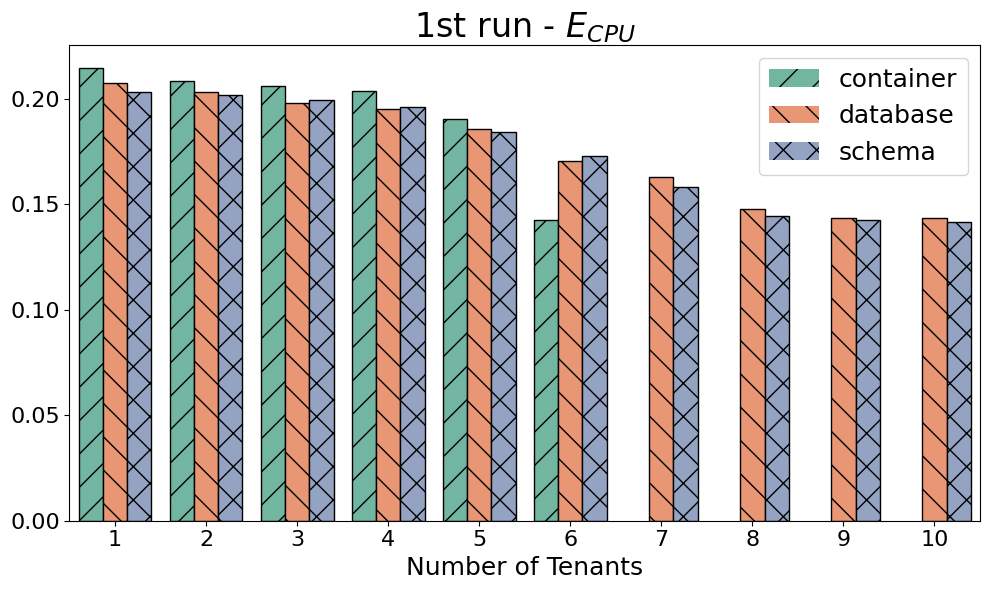

In [25]:
plot_bars(merged_df, y='E_CPU', title='1st run - $E_{CPU}$', estimator='max')

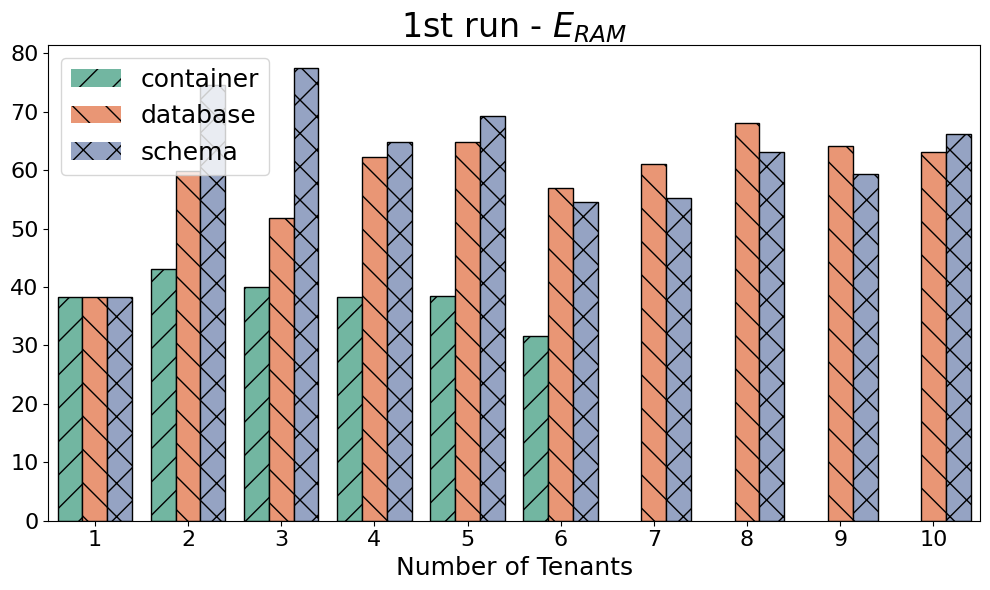

In [26]:
plot_bars(merged_df, y='E_RAM', title='1st run - $E_{RAM}$', estimator='max')

In [27]:
client = 2

df_performance_monitoring = collect.get_monitoring_all(type="stream")
df_performance_monitoring["client"] = df_performance_monitoring["client"].astype(int)
df_performance_monitoring = df_performance_monitoring[df_performance_monitoring['client'] == client]
df_performance = collect.get_performance_all()
df_performance["client"] = df_performance["client"].astype(int)
df_performance = df_performance[df_performance['client'] == client]
merged_df = pd.merge(df_performance, df_performance_monitoring, on=['type', 'num_tenants', 'client'], how='inner')
merged_df['RAM/Throughput'] = merged_df['Max RAM [Gb]'] / (merged_df['Throughput@Size'])
merged_df['CPUs/Throughput'] = merged_df['CPU [CPUs]'] / (merged_df['Throughput@Size'] / 3600.)
#merged_df['E_RAM'] = (merged_df['Throughput@Size']) / merged_df['Max RAM [Gb]']
#merged_df['E_CPU'] = (merged_df['Throughput@Size'] * 3600.) / merged_df['CPU [CPUs]']
merged_df['E_CPU'] = (10. * merged_df['num_tenants'] * merged_df['num_of_queries'] * merged_df['SF']) / merged_df['CPU [CPUs]']
merged_df['E_RAM'] = (10. * merged_df['num_tenants'] * merged_df['num_of_queries'] * merged_df['SF']) / merged_df['Max RAM [Gb]']

merged_df

,client,Throughput@Size,time [s],num_of_queries,SF,count,Power@Size [~Q/h],type,num_tenants,CPU [CPUs],...,Sync Time,Write Time,Number Autoanalyze,Number Autovacuum,Cache Hit Ratio [%],Variance of Core Util [%],RAM/Throughput,CPUs/Throughput,E_CPU,E_RAM
0,2,818.60,1935,22,10.0,2,6392.959585,container,2,20536.07,...,0.0,0.0,0.0,0.0,NaN,0.0,0.142512,90312.548253,0.214257,37.716441
1,2,798.79,1983,22,10.0,2,6205.299555,database,2,21213.02,...,0.0,0.0,0.0,0.0,NaN,0.0,0.092628,95603.189825,0.207420,59.467496
2,2,793.19,1997,22,10.0,2,6193.703735,schema,2,21532.46,...,0.0,0.0,0.0,0.0,NaN,0.0,0.092878,97727.979425,0.204343,59.725804
3,2,412.29,1921,22,10.0,1,6399.072262,container,1,10563.69,...,0.0,0.0,0.0,0.0,NaN,0.0,0.141478,92239.161755,0.208261,37.716441
4,2,402.64,1967,22,10.0,1,6270.759668,database,1,10686.47,...,0.0,0.0,0.0,0.0,NaN,0.0,0.144894,95547.615736,0.205868,37.709976
5,2,398.19,1989,22,10.0,1,6236.568739,schema,1,10890.06,...,0.0,0.0,0.0,0.0,NaN,0.0,0.146488,98456.053643,0.202019,37.716441
6,2,1188.00,2000,22,10.0,3,6266.801892,container,3,32211.67,...,0.0,0.0,0.0,0.0,NaN,0.0,0.146254,97611.121212,0.204895,37.985612
7,2,1156.20,2055,22,10.0,3,6033.349474,database,3,33425.27,...,0.0,0.0,0.0,0.0,NaN,0.0,0.111278,104074.530358,0.197455,51.297995
8,2,1159.02,2050,22,10.0,3,6073.307784,schema,3,33183.98,...,0.0,0.0,0.0,0.0,NaN,0.0,0.101172,103071.843454,0.198891,56.285178
9,2,1502.13,2109,22,10.0,4,5907.812948,schema,4,45464.51,...,0.0,0.0,0.0,0.0,NaN,0.0,0.087948,108960.100657,0.193558,66.611157


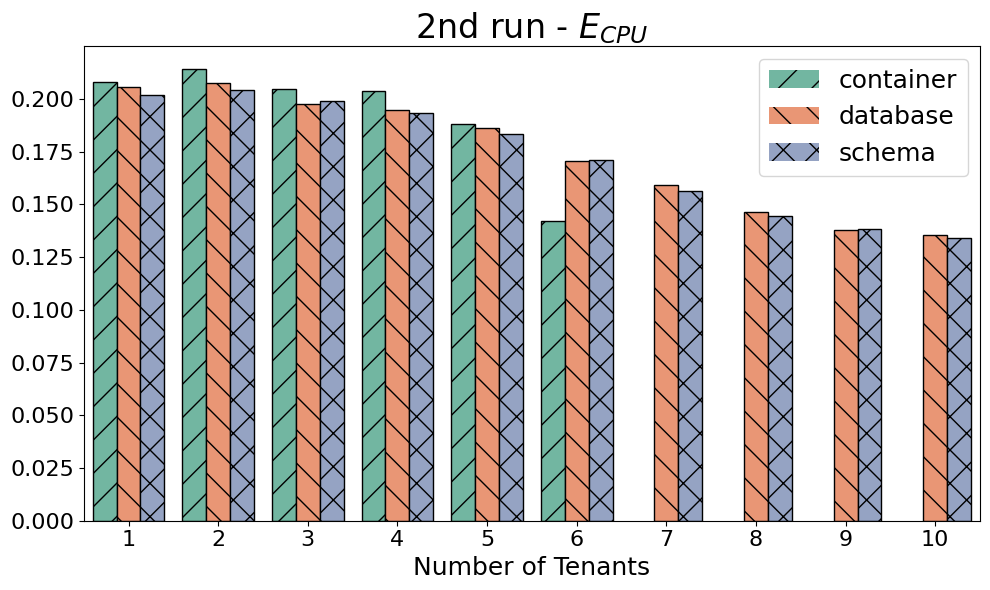

In [28]:
plot_bars(merged_df, y='E_CPU', title='2nd run - $E_{CPU}$', estimator='max')

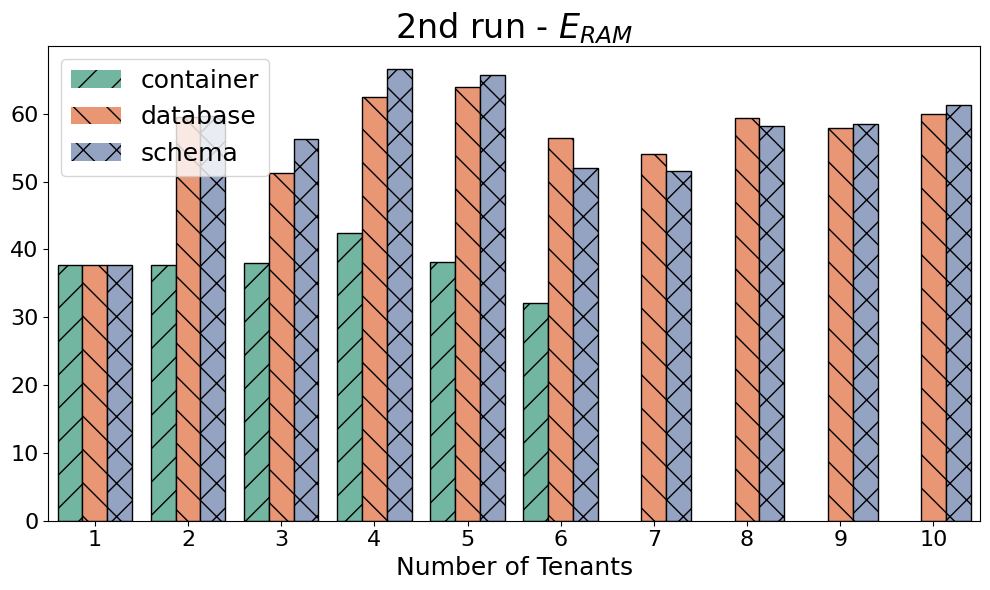

In [29]:
plot_bars(merged_df, y='E_RAM', title='2nd run - $E_{RAM}$', estimator='max')

In [30]:
import os
import zipfile

def zip_all_results():
    # Set the base directory containing the folders
    base_dir = path # "/path/to/your/folders"  # CHANGE THIS to your actual directory
    # List all folder names in the directory
    folder_names = codes
    # Create a zip for each folder
    for folder in folder_names:
        folder_path = os.path.join(base_dir, folder)
        zip_path = os.path.join(base_dir, f"{folder}.zip")
        print(f"Zipping {folder_path} to {zip_path}...")
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for root, _, files in os.walk(folder_path):
                for file in files:
                    abs_path = os.path.join(root, file)
                    rel_path = os.path.relpath(abs_path, folder_path)
                    zipf.write(abs_path, arcname=os.path.join(folder, rel_path))
    print("✅ Done zipping all folders.")


In [31]:
#zip_all_results()